In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy import optimize
from scipy.optimize import curve_fit
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
from matplotlib.ticker import MultipleLocator, MaxNLocator,FuncFormatter, ScalarFormatter
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from __future__ import division
from scipy.optimize import check_grad
from scipy.optimize import differential_evolution
import warnings
import tensorflow as tf
import datetime, os
import hyperopt
from hyperopt import fmin, tpe, hp
from decimal import *
import time
import numpy as np
from scipy.ndimage.interpolation import shift
import matplotlib.pylab as plt

# Método numérico - SEIRD

In [2]:
def SEIRD2(y,t,a11,a12,a21,a22,b1,b2,gamma1,gamma2,mu1,mu2):  

    S1=y[0]
    E1=y[2]
    I1=y[4]
    R1=y[6]
    D1=y[8]
    S2=y[1]
    E2=y[3]
    I2=y[5]
    R2=y[7]
    D2=y[9]
    
    V1=(a11)*I1+(a12)*I2
    V2=(a21)*I1+(a22)*I2

    dS1dt=-V1*S1
    dE1dt=V1*S1 - b1*E1
    dI1dt=b1*E1-(gamma1+mu1)*I1
    dR1dt=gamma1*I1
    dD1dt=mu1*I1
    
    dS2dt=-V2*S2
    dE2dt=V2*S2 - b2*E2
    dI2dt=b2*E2-(gamma2+mu2)*I2
    dR2dt=gamma2*I2
    dD2dt=mu2*I2
       
    
    return [dS1dt,dS2dt,dE1dt,dE2dt,dI1dt,dI2dt,dR1dt,dR2dt,dD1dt,dD2dt]

In [3]:
def Jac_SEIRD2(y,t,a11,a12,a21,a22,b1,b2,gamma1,gamma2,mu1,mu2):  
    
    S1=y[0]
    E1=y[2]
    I1=y[4]
    R1=y[6]
    D1=y[8]
    
    S2=y[1]
    E2=y[3]
    I2=y[5]
    R2=y[7]
    D2=y[9]
    
    V1=(a11)*I1+(a12)*I2
    V2=(a21)*I1+(a22)*I2

    J=[[-V1,0,0,0,-(a11)*S1,-(a12)*S1,0,0,0,0],[0,-V2,0,0,-(a21)*S2,-(a22)*S2,0,0,0,0], 
       [V1,0,-b1,0,(a11)*S1,(a12)*S1,0,0,0,0], [0,V2,0,-b2,-(a21)*S2,-(a22)*S2,0,0,0,0],
       [0,0,b1,0,-(gamma1+mu1),0,0,0,0,0], [0,0,0,b2,0,-(gamma2+mu2),0,0,0,0],
       [0,0,0,0,gamma1,0,0,0,0,0], [0,0,0,0,0,gamma2,0,0,0,0],
       [0,0,0,0,mu1,0,0,0,0,0],[0,0,0,0,0,mu2,0,0,0,0]]
    
    return J

In [4]:
DiasdoMes = np.array(["5 Mar","6 Mar","7 Mar","8 Mar","9 Mar","10 Mar", "11 Mar","12 Mar","13 Mar", 
                 "14 Mar","15 Mar", "16 Mar","17 Mar", "18 Mar", "19 Mar","20 Mar","21 Mar","22 Mar","23 Mar",
                 "24 Mar","25 Mar","26 Mar","27 Mar","28 Mar","29 Mar","30 Mar","31 Mar","1 Apr","2 Apr","3 Apr"])
Tempo=DiasdoMes

# Exemplo NY

In [5]:
#Dados passados pelo Alison em Janeiro

confViz=np.array([0.000000,     0.400000,     1.233333,     2.233333,     4.233333,     6.661905,
                  9.090476,    15.376190,   24.519048,    39.376190,   59.947619,    93.090476,
                  158.519048,   301.376190,   556.661905,   897.090476,  1436.804762,  2111.947619,
                  3004.947619,  4069.233333,  5547.376190,  7251.804762,  9132.376190, 11289.376190,
                  13594.661905, 16170.233333, 18949.804762, 21694.233333, 24590.233333, 27989.376190])

confNY=np.array([1.000000,    1.600000,    2.766667,    3.766667,    5.195238,    7.480952,    9.909524,
                15.052381,   21.338095,   30.338095,   39.480952,   53.766667,   90.909524,  172.623810,
                 315.338095,  496.195238,  752.195238, 1037.909524, 1389.480952, 1762.338095, 2194.623810,
                 2624.338095, 3076.338095, 3558.338095, 4059.766667, 4558.052381, 5079.766667, 5566.338095,
                 6045.195238, 6612.909524])

In [6]:
#Os dados de casos a seguir foram obtidos pela média móvel de 7 dias anterior do númedo de NOVOS casos diários 
#e depois somando.



#confViz=np.array([0.285714286,0.571428571,1.285714286,2.285714286,4.285714286,6.714285714,9.142857143,
#                  15.42857143,24.57142857,39.42857143,60,93.14285714,158.5714286,301.4285714,556.7142857,
#                  897.1428571,1436.857143,2112,3005,4069.285714,5547.428571,7251.857143,9132.428571,
#                  11289.42857,13594.71429,16170.28571,18949.85714,21694.28571,24590.28571,27989.42857])

#confNY=np.array([0.857142857,1.428571429,2.571428571,3.714285714,5.142857143,7.428571429,9.857142857,15,
#                 21.28571429,30.28571429,39.42857143,53.71428571,90.85714286,172.5714286,315.2857143,
#                 496.1428571,752.1428571,1037.857143,1389.428571,1762.285714,2194.571429,2624.285714,
#                 3076.285714,3558.285714,4059.714286,4558,5079.714286,5566.285714,6045.142857, 6612.857143])

conf=confNY+confViz


#Os dados de mortes são a média móvel de 7 dias anteriores


mortesViz=np.array([0.0000000,   0.0000000,   0.0000000,   0.0000000,   0.1428571,   0.2857143,   0.4285714,
                    0.5714286,   0.7142857,   0.8571429,   1.1428571,   1.5714286,   2.0000000,   2.4285714,
                    3.1428571,   4.0000000,   5.2857143,  11.5714286,  22.5714286,  39.8571429,  64.0000000,
                    95.8571429, 135.8571429, 194.1428571, 257.7142857, 327.5714286, 411.4285714, 520.2857143,
                    648.0000000, 794.1428571])

mortesNY=np.array([0.000000,   0.000000,   0.000000,   0.000000,   0.000000,   0.000000,   0.000000,
                   0.000000,   0.000000,   0.000000,   0.000000,   0.000000,   0.000000,   0.000000,
                   0.000000,   0.000000,   0.000000,   1.428571,   4.142857,   9.142857,  15.285714,
                   23.142857,  32.428571,  45.714286,  59.000000,  73.285714,  86.714286, 104.142857,
                   121.714286, 143.142857])


NumDays=len(mortesNY)
mortes=mortesViz+mortesNY


# Alison 15/ago === primeiro===
#b11=1.362834e-07
#b12=5.763959e-08
#b21=9.335943e-09
#b22=6.154893e-08
#a=1/3
#mu1=0.006614284
#mu2=0.008994874
#gamma=0.1678806
#E10=3.587489
#E20=189.5482


# Alison 15/ago === segundo===
#b11= 1.313516e-07
#b12= 6.014798e-08
#b21= 1.164526e-09
#b22= 6.432068e-08
#a= 0.333333
#mu1= 0.006783074
#mu2= 0.009600811
#gamma= 0.1782233
#E10= 0.073459
#E20= 197.3383

# === terceiro===
#b11=2.472308e-07 
#b12=1.769661e-09 
#b21=1.537126e-07 
#b22=4.995852e-09 
#a= 0.3 
#mu1=0.004603178 
#mu2=0.007113742 
#gamma=0.1016965 
#E10=99.35483 
#E20=1.78247



# === quarto ====

#b11= 2.239437e-07
#b12= 1.597219e-10
#b21= 1.414581e-07
#b22= 2.979664e-09
#a= 0.3
#mu1= 0.004060127
#mu2= 0.006217964
#gamma= 0.07686948
#E10= 113.4915
#E20= 1.149483

#==== quinto =====
#b11=1.438002e-07 
#12=6.310993e-08 
#b21=1.072332e-08 
#b22=6.68603e-08 
#a= 0.3 
#mu1=0.006834952 
#mu2=0.009647822 
#gamma=0.1797832 
#E10=4.119216 
#E20=188.3812


#===== sexto ======
#b11=1.302697e-07 
#b12=6.128739e-08 
#b21=2.475656e-09 
#b22=6.39265e-08 
#a= 0.3 
#mu1=0.006415728 
#mu2=0.008728864 
#gamma=0.1551327 
#E10=1.595149 
#E20=192.7423

#===== sétimo =====
#b11=1.275503e-07 
#b12=6.149301e-08 
#b21=2.198188e-09 
#b22=6.446803e-08 
#a= 0.3 
#mu1=0.006494481 
#mu2=0.008746544 
#gamma=0.1556853 
#E10=0.6228001 
#E20=189.5582

#===== oitavo =====
#b11=1.28104e-07 
#12=5.618179e-08 
#b21=2.49455e-09 
#b22=5.835198e-08 
#a= 0.3 
#mu1=0.005840508 
#mu2=0.007975449 
#gamma=0.1455118
#E10=0.8716916 
#E20=260.823

#=====nono=====
#b11=1.167082e-07 
#b12=5.24066e-08 
#b21=1.883664e-09 
#b22=5.541086e-08 
#a= 0.3 
#mu1=0.005897493 
#mu2=0.007728451 
#gamma=0.1358446 
#E10=0.2183988 
#E20=291.9036

#===== 10º =====
#b11=9.667374e-08 
#b12=4.868902e-08 
#b21=1.582792e-09 
#b22=5.021763e-08 
#a= 0.315
#mu1=0.005397821 
#mu2=0.0071377 
#gamma=0.1016353 
#E10=0.1465221 
#E20=291.9652



#=======11º========
#b11=1.029253e-07 
#b12=4.686218e-08 
#b21=8.785129e-09 
#b22=4.83973e-08 
#a=0.31 
#mu1=0.005447275 
#mu2=0.007168111 
#gamma=0.1064956 
#E10=1.105992 
#E20=300.8411

#=======12º========
#b11=9.861817e-08 
#b12=5.045563e-08 
#b21=1.668626e-09 
#b22=5.195747e-08 
#a=0.315 
#mu1=0.005662014 
#mu2=0.00701271 
#gamma=0.1194878 
#E10=3.073295 
#E20=287.1003

#=======13º========

#b11=8.896781e-08 
#b12=4.561362e-08 
#b21=5.447462e-10 
#b22=4.709082e-08 
#a=0.32 
#mu1=0.00521101 
#mu2=0.006897641 
#gamma=0.09188311 
#E10=0.4084842 
#E20=295.9739

#======14º=========

#b11= 1.647913e-07
#b12= 5.882963e-08
#b21= 2.39241e-08
#b22= 6.037258e-08
#a= 0.332475
#mu1=0.006455591
#mu2= 0.009606232
#gamma=0.1905646
#E10=1.622102
#E20=215.8127

#======15º========
#b11=1.229213e-07 
#b12=4.801949e-08 
#b21=8.826909e-09 
#b22=4.922669e-08 
#a=0.330742 
#mu1=0.005213005 
#mu2=0.007515871 
#gamma=0.1162846 
#E10=1.919374 
#E20=274.0633

#======16º========
#b11=1.550773e-07 
#b12=4.544716e-08 
#b21=4.756015e-08 
#b22=4.800922e-08 
#a= 0.3 
#mu1=0.005397755 
#mu2=0.008474008 
#gamma=0.1248658 
#E10=96.99387 
#E20=96.93782


#======17º========
b11= 1.883597e-07
b12= 5.504316e-08
b21= 5.609301e-08
b22= 5.817231e-08
a= 0.3
mu1= 0.006640271
mu2= 0.01034966
gamma= 0.192012
E10= 81.68885
E20= 94.6416

a1=a
a2=a
gamma1=gamma
gamma2=gamma


N=10500000 
N1=0.16*N  #NY
N2=0.84*N  #Vizinhos



V1=(b21-b11)/mu1
V2=(b22-b12)/mu2


I10=confNY[0]
I20=confViz[0]
S10=N1-E10-I10
S20=N2-E20-I20


In [7]:
t = np.linspace(0, NumDays-1, NumDays)  #tempo por dias
dt = 1/10
t1 = np.linspace(0, NumDays-1, int((NumDays-1)/dt)+1)

In [8]:
print(f'V1={V1}\nV2={V2}')

V1=-1.9918869275064224e-05
V2=3.0234326538263054e-07


# Gráficos das soluções baseadas em dados de 1 população

In [9]:
t = np.linspace(0, NumDays-1, NumDays)  #tempo por dias
y0=[S10,S20,E10,E20,I10,I20,0,0,0,0]
sol=odeint(SEIRD2,y0,t1,args=(b11,b12,b21,b22,a1,a2,gamma1,gamma2,mu1,mu2))
y=sol[(t/dt).astype(int)]
InfectadosTotalNY= y[:,4]+y[:,6]+y[:,8]
InfectadosTotalViz=y[:,5]+y[:,7]+y[:,9]
MortesNY=y[:,8]
MortesViz=y[:,9]


ErroCasosViz = mean_absolute_error(InfectadosTotalViz,confViz)
ErroMortesViz = mean_absolute_error(MortesViz,mortesViz)



ErroCasosNY = mean_absolute_error(InfectadosTotalNY,confNY)
ErroMortesNY = mean_absolute_error(MortesNY,mortesNY)

legsize=22
colorcases='blue'
colordeaths='red'
colordata='black'
linewidth=4
markersize=7
fontaxis=20



t=DiasdoMes
tamfonte=25
fig=plt.figure(figsize=(18,10))

ax1 = fig.add_subplot(2,2,1)
ax1.plot(t, confViz, 'o',color=colordata,label = "Mean of cases ",ms=markersize)
ax1.plot(t,InfectadosTotalViz, color=colorcases,label = "$C_1(t)$",lw=linewidth)
ax1.legend(fontsize=legsize)
ax1.xaxis.set_major_locator(plt.MultipleLocator(5.8))
plt.xticks(fontsize=fontaxis)
plt.yticks(fontsize=fontaxis)
ax1.set_title("(a) Infectious Cases in the neighbouring Counties",fontsize=tamfonte)


ax2 = fig.add_subplot(2,2,2)
ax2.plot(t, mortesViz, 'o',color=colordata,label = "Mean of deaths",ms=markersize)
ax2.plot(t, MortesViz, color=colordeaths,label = "$D_1(t)$",lw=linewidth)
ax2.legend(fontsize=legsize)
ax2.xaxis.set_major_locator(plt.MultipleLocator(5.8))
plt.xticks(fontsize=fontaxis)
plt.yticks(fontsize=fontaxis)
ax2.set_title("(b) Deaths in the neighbouring Counties",fontsize=tamfonte)

ax3 = fig.add_subplot(2,2,3)
ax3.plot(t, confNY, 'o',color=colordata,label = "Mean of cases",ms=markersize)
ax3.plot(t, InfectadosTotalNY, color=colorcases,label = "$C_2(t)$",lw=linewidth)
ax3.legend(fontsize=legsize)
ax3.xaxis.set_major_locator(plt.MultipleLocator(5.8))
plt.xticks(fontsize=fontaxis)
plt.yticks(fontsize=fontaxis)
ax3.set_title("(c) Infectious cases in NY County",fontsize=tamfonte)

ax4 = fig.add_subplot(2,2,4)
ax4.plot(t, mortesNY, 'o',color=colordata,label = "Mean of deaths",ms=markersize)
ax4.plot(t, MortesNY, color=colordeaths,label = "$D_2(t)$",lw=linewidth)
ax4.legend(fontsize=legsize)
ax4.xaxis.set_major_locator(plt.MultipleLocator(5.8))
plt.xticks(fontsize=fontaxis)
plt.yticks(fontsize=fontaxis)
ax4.set_title(f"(d) Deaths in NY County",fontsize=tamfonte)



#fig.subplots_adjust(bottom=0.05, right=1, top=0.97, left=0.05)
fig.tight_layout()
plt.show()
#fig.savefig('AjustePor2Novo.png',dpi=400)


t = np.linspace(0, NumDays-1, NumDays)

print(f"Distância Viz:= {max(abs(confViz-InfectadosTotalViz)):.2f}")  
print(f"Distância Mortes Viz:= {max(abs(MortesViz-mortesViz)):.2f}")  
print(f"Distância Mortes NY:= {max(abs(MortesNY-mortesNY)):.2f}")  
print(f'V1 = {abs(V1):.10f}')
print(f'V2 = {abs(V2):.10f}')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Distância Viz:= 2890.93
Distância Mortes Viz:= 61.46
Distância Mortes NY:= 13.98
V1 = 0.0000199189
V2 = 0.0000003023


In [10]:
D=27
print(f'Erro casos Viz: {mean_absolute_error(confViz[:D],InfectadosTotalViz[:D]):.2f}')
print(f'Erro casos NY: {mean_absolute_error(confNY[:D],InfectadosTotalNY[:D]):.2f}')
print(f'Erro mortes Viz: {mean_absolute_error(mortesViz[:D],MortesViz[:D]):.2f}')
print(f'Erro mortes NY: {mean_absolute_error(mortesNY[:D],MortesNY[:D]):.2f}')

Erro casos Viz: 819.00
Erro casos NY: 312.23
Erro mortes Viz: 23.83
Erro mortes NY: 5.54


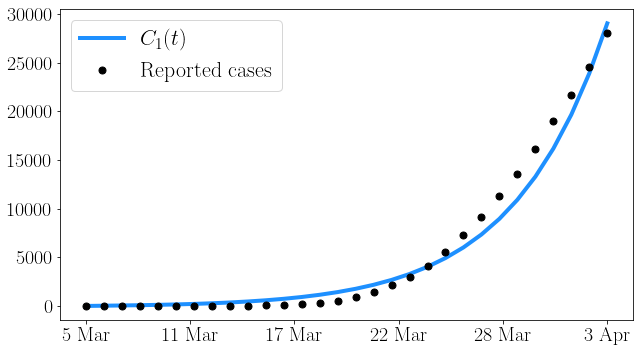

In [11]:
t=DiasdoMes
colorcases='dodgerblue'
fig=plt.figure(figsize=(9,5))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(t,InfectadosTotalViz, color=colorcases,label = "$C_1(t)$",lw=linewidth)
ax1.plot(t, confViz, 'o',color=colordata,label = "Reported cases ",ms=markersize)
ax1.legend(fontsize=legsize)
ax1.xaxis.set_major_locator(plt.MultipleLocator(5.8))
plt.xticks(fontsize=fontaxis)
plt.yticks(fontsize=fontaxis)
fig.tight_layout()
plt.show()
fig.savefig('CasosViz.png',dpi=400)




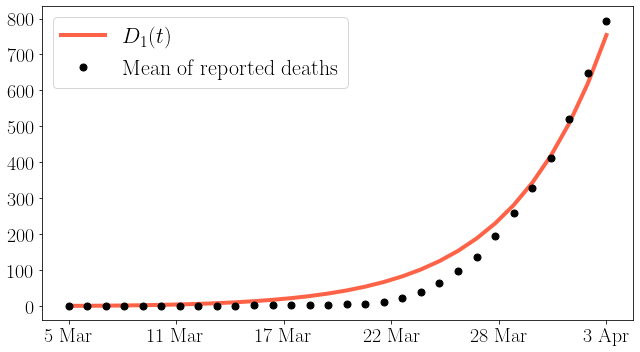

In [12]:
colordeaths='tomato'
fig=plt.figure(figsize=(9,5))
ax2 = fig.add_subplot(1,1,1)
ax2.plot(DiasdoMes, MortesViz, color=colordeaths,label = "$D_1(t)$",lw=linewidth)
ax2.plot(DiasdoMes, mortesViz, 'o',color=colordata,label = "Mean of reported deaths",ms=markersize)
ax2.legend(fontsize=legsize)
ax2.xaxis.set_major_locator(plt.MultipleLocator(5.8))
plt.xticks(fontsize=fontaxis)
plt.yticks(fontsize=fontaxis)
fig.tight_layout()
plt.show()
fig.savefig('MortesViz.png',dpi=400)



In [13]:
fig=plt.figure(figsize=(9,5))
ax3 = fig.add_subplot(1,1,1)
ax3.plot(DiasdoMes, InfectadosTotalNY, color=colorcases,label = "$C_2(t)$",lw=linewidth)
ax3.plot(DiasdoMes, confNY, 'o',color=colordata,label = "Reported cases",ms=markersize)
ax3.legend(fontsize=legsize)
ax3.xaxis.set_major_locator(plt.MultipleLocator(5.8))
plt.xticks(fontsize=fontaxis)
plt.yticks(fontsize=fontaxis)
fig.tight_layout()
plt.show()
fig.savefig('CasosNY.png',dpi=400)




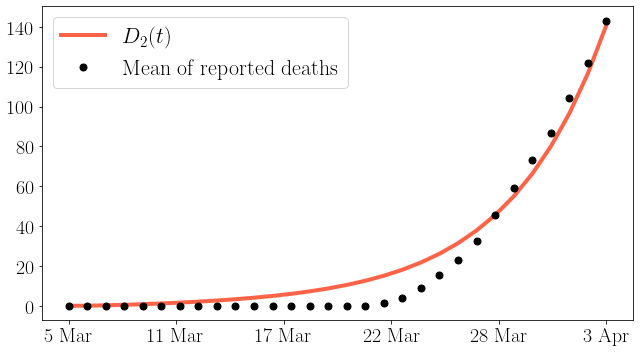

In [14]:
fig=plt.figure(figsize=(9,5))
ax4 = fig.add_subplot(1,1,1)
ax4.plot(DiasdoMes, MortesNY, color=colordeaths,label = "$D_2(t)$",lw=linewidth)
ax4.plot(DiasdoMes, mortesNY, 'o',color=colordata,label = "Mean of reported deaths",ms=markersize)
ax4.legend(fontsize=legsize)
ax4.xaxis.set_major_locator(plt.MultipleLocator(5.8))
plt.xticks(fontsize=fontaxis)
plt.yticks(fontsize=fontaxis)
fig.tight_layout()
plt.show()
fig.savefig('MortesNY.png',dpi=400)


In [15]:
#Soluções Calculadas
# NY
S1=y[:,0]
E1=y[:,2]
I1=y[:,4]
R1=y[:,6]
D1=y[:,8]

IRD1=I1+R1+D1

#Vizinhos
S2=y[:,1]
E2=y[:,3]
I2=y[:,5]
R2=y[:,7]
D2=y[:,9]

IRD2=I2+R2+D2


# Trocando Pop 1 por Pop 2 pra usar mesma notação do artigo

In [16]:
#População 1 = Vizinhos
#População 2 = NY

S10,S20=S20,S10
b11, b12, b21, b22 = b22, b21, b12, b11
mu1, mu2 = mu2, mu1

V1=(b21-b11)/mu1
V2=(b22-b12)/mu2


gamma1, gamma2= gamma2,gamma1

E10, E20 = E20, E10
I10, I20 = I20, I10

S1,E1,I1,R1,D1,S2,E2,I2,R2,D2 = S2,E2,I2,R2,D2,S1,E1,I1,R1,D1
C1=I1+R1+D1
C2=I2+R2+D2
t = np.linspace(0, NumDays-1, NumDays)

In [17]:
Dt1=mortesViz
Dt2=mortesNY

In [18]:
expostosViz=(confViz-shift(confViz, +1, cval=0))/(a)
expostosViz[0]=E10

St1Viz=N2-expostosViz-confViz
#St1Viz[-1]=St1Viz[-2]


expostosNY=(confNY-shift(confNY, +1, cval=0))/(a)
expostosNY[0]=E20

St2NY=N1-expostosNY-confNY
#St2NY[-1]=St2NY[-2]

In [19]:
plt.plot(t,St1Viz,'.',color='blue')
plt.plot(t,S1,color='orange')
plt.show()
St1Viz[0]

8819905.3584

In [20]:
ErroS=np.abs(S1[:25]-St1Viz[:25])
print(f"Max ErroS:= {max(ErroS):.2f}")  
print(f"V1 = {V1}")
print(f"V2 = {V2}")

Max ErroS:= 3622.00
V1 = -3.0234326538263054e-07
V2 = 1.9918869275064224e-05


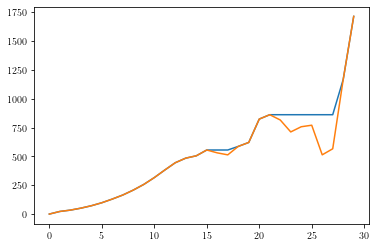

KS(dia = 20)=860.99


In [21]:
ErroS=np.abs(S1-St1Viz)
ErroD=np.maximum(np.abs(D1-Dt1),np.abs(D2-Dt2))

KS_t=S2*(1-(1-ErroS/S1)*np.exp(-(abs(V1)*np.abs(D1-Dt1)+abs(V2)*np.abs(D2-Dt2))))
KS_t2=S2*(1-(1-ErroS/S1)*np.exp(-((V1)*(D1-Dt1)+(V2)*(D2-Dt2))))


#KS_t=(KS_t+KS_t2)/2
#KS_t=KS_t2

KS=0*t
for d in t.astype(int):
    KS[d] = max(np.abs(KS_t[:d+1]))
plt.plot(t,KS,t,KS_t)
plt.show()
print(f'KS(dia = 20)={KS[21]:.2f}')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


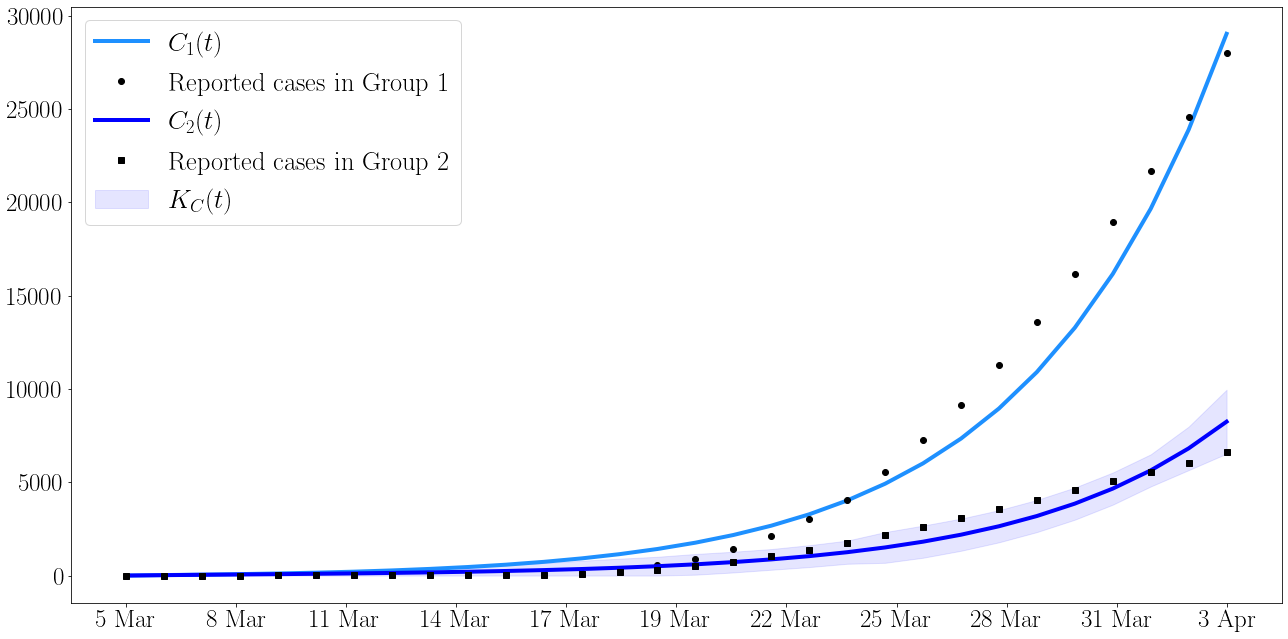

In [22]:
#Erro baseado em S e E
t = np.linspace(0, NumDays-1, NumDays)  #eixo horizontal em dias contados
D=30
#e_alpha=max(abs(1/4-a),abs(a-1/5))
#logM=max(abs(np.log(1-e_alpha/a)),abs(np.log(1+e_alpha/a)))
ErroCR2=KS[:D]  #+E20*t*np.exp(-a*t)*e_alpha+(S2[0]-S2)*logM

CR1=I1[:D]+R1[:D]+D1[:D]
CRt1=confViz[:D]
ErroCR1=0*t[:D]
for d in t[:D].astype(int):
    ErroCR1[d]=max(np.abs(CR1[:d+1]-CRt1[:d+1]))

CR2=I2[:D]+R2[:D]+D2[:D]
CRt2=confNY[:D]

linecolorViz='dodgerblue'
linecolorNY='blue'
markercolor='black'
alfacolor='blue' 
markersize=6
linewidth=4
tamfonte=25

Tempo=DiasdoMes[:D] #Eixo horizontal em dias do mês

fig=plt.figure(figsize=(18,9))
ax = fig.add_subplot(1,1,1)
#ax.set_title("Estimate on cumulative number of infectious cases",fontsize=tamfonte)

g1,=plt.plot(Tempo,CR1,color=linecolorViz,label='$C_{1}(t)$',lw=linewidth)
g2,=plt.plot(Tempo,CRt1,'o',color=markercolor,label='Reported cases in Group 1',ms=markersize)
#ax.xaxis.set_major_locator(plt.MultipleLocator(2.9))
#g3=plt.fill_between(Tempo,CR1+ErroCR1,CR1-ErroCR1,alpha=0.1,label='$\|C_1-\widetilde{C}_1\|_{[0,t]}$',color=alfacolor)

g4,=plt.plot(Tempo,CR2,color=linecolorNY,label='$C_{2}(t)$',lw=linewidth)
g5,=plt.plot(Tempo,CRt2,'s',color=markercolor,label='Reported cases in Group 2',ms=markersize)
ax.xaxis.set_major_locator(plt.MultipleLocator(2.9))
g6=plt.fill_between(Tempo,CR2+ErroCR2,np.maximum(CR2-ErroCR2,0),alpha=0.1,label='$K_{C}(t)$',color=alfacolor)



ax.legend(handles=[g1,g2,g4,g5,g6],fontsize=1.2*legsize)
#ax.legend(handles=[g4,g5,g6],fontsize=1.2*legsize)

plt.xticks(fontsize=tamfonte)
plt.yticks(fontsize=tamfonte)

#plt.text(0,10000,"$K_{NY}(30)$"+f"={ErroCR2[-1]:.2f}",fontsize=40)
#plt.text(0,7000,"$K_{NY}(30)/C_{NY}(30)=$"+f"{ErroCR2[-1]/CR2[-1]:.2f}",fontsize=30)
#plt.text(0,5000,"$K_{NY}(30)/$Confirmados(30)="+f"{ErroCR2[-1]/CRt2[-1]:.2f}",fontsize=30)
fig.tight_layout()
plt.show()
fig.savefig('ErroEstimativa.png',dpi=500)



In [23]:
for D in range(2):
    D=D+1
    print(f'Dia {-D} Erro C2 = {100*ErroCR2[-D]/CR2[-D]:.2f}% ({ErroCR2[-D]:.2f}/{CR2[-D]:.2f})')
    print(f'Dia {-D} Erro C1 = {100*ErroCR1[-D]/CR1[-D]:.2f}% ({ErroCR1[-D]:.2f}/{CR1[-D]:.2f})')
    print()

Dia -1 Erro C2 = 20.78% (1713.09/8245.81)
Dia -1 Erro C1 = 9.96% (2890.93/29027.75)

Dia -2 Erro C2 = 17.11% (1166.39/6815.33)
Dia -2 Erro C1 = 12.10% (2890.93/23890.01)



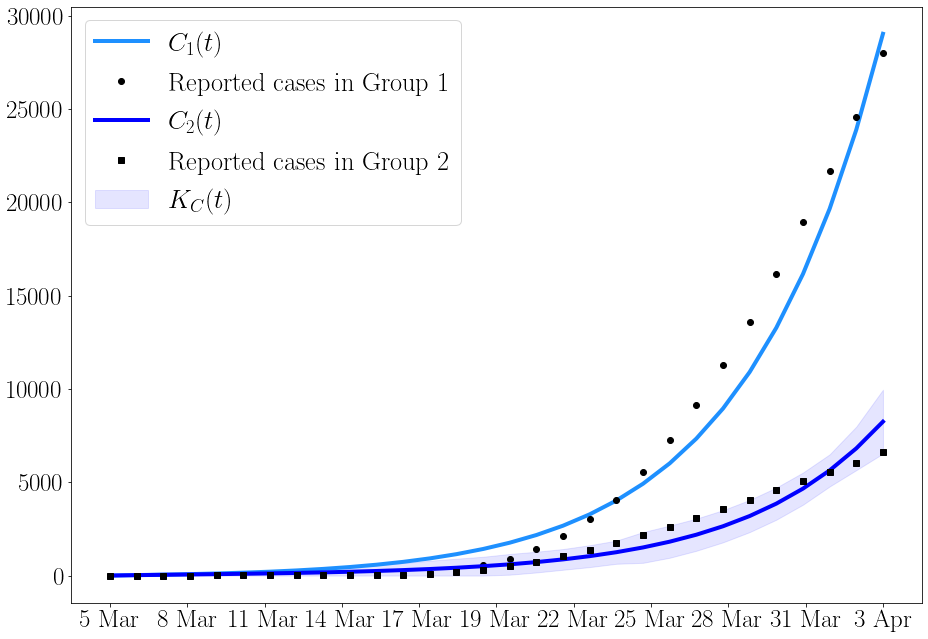

In [25]:
#Erro baseado em S e E
t = np.linspace(0, NumDays-1, NumDays)  #eixo horizontal em dias contados
D=30
#e_alpha=max(abs(1/4-a),abs(a-1/5))
#logM=max(abs(np.log(1-e_alpha/a)),abs(np.log(1+e_alpha/a)))
ErroCR2=KS[:D]  #+E20*t*np.exp(-a*t)*e_alpha+(S2[0]-S2)*logM

CR1=I1[:D]+R1[:D]+D1[:D]
CRt1=confViz[:D]
ErroCR1=0*t[:D]
for d in t[:D].astype(int):
    ErroCR1[d]=max(np.abs(CR1[:d+1]-CRt1[:d+1]))

CR2=I2[:D]+R2[:D]+D2[:D]
CRt2=confNY[:D]

linecolorViz='dodgerblue'
linecolorNY='blue'
markercolor='black'
alfacolor='blue' 
markersize=6
linewidth=4
tamfonte=25

Tempo=DiasdoMes[:D] #Eixo horizontal em dias do mês

fig=plt.figure(figsize=(13,9))
ax = fig.add_subplot(1,1,1)
#ax.set_title("Estimate on cumulative number of infectious cases",fontsize=tamfonte)

g1,=plt.plot(Tempo,CR1,color=linecolorViz,label='$C_{1}(t)$',lw=linewidth)
g2,=plt.plot(Tempo,CRt1,'o',color=markercolor,label='Reported cases in Group 1',ms=markersize)
#ax.xaxis.set_major_locator(plt.MultipleLocator(2.9))
#g3=plt.fill_between(Tempo,CR1+ErroCR1,CR1-ErroCR1,alpha=0.1,label='$\|C_1-\widetilde{C}_1\|_{[0,t]}$',color=alfacolor)

g4,=plt.plot(Tempo,CR2,color=linecolorNY,label='$C_{2}(t)$',lw=linewidth)
g5,=plt.plot(Tempo,CRt2,'s',color=markercolor,label='Reported cases in Group 2',ms=markersize)
ax.xaxis.set_major_locator(plt.MultipleLocator(2.9))
g6=plt.fill_between(Tempo,CR2+ErroCR2,np.maximum(CR2-ErroCR2,0),alpha=0.1,label='$K_{C}(t)$',color=alfacolor)



ax.legend(handles=[g1,g2,g4,g5,g6],fontsize=1.2*legsize)
#ax.legend(handles=[g4,g5,g6],fontsize=1.2*legsize)

plt.xticks(fontsize=tamfonte)
plt.yticks(fontsize=tamfonte)

#plt.text(0,10000,"$K_{NY}(30)$"+f"={ErroCR2[-1]:.2f}",fontsize=40)
#plt.text(0,7000,"$K_{NY}(30)/C_{NY}(30)=$"+f"{ErroCR2[-1]/CR2[-1]:.2f}",fontsize=30)
#plt.text(0,5000,"$K_{NY}(30)/$Confirmados(30)="+f"{ErroCR2[-1]/CRt2[-1]:.2f}",fontsize=30)
fig.tight_layout()
plt.show()
fig.savefig('ErroEstimativaPoster.png',dpi=500)

